# Notebook n°5: Détection d'attributs faciaux (genre, âge, ethnicité) à l'aide d'un modèle personnalisé
### Source : del Rio, D. (2022, 21 janvier). Multitask Gender, Age, Ethnicity (92.2 % Acc). Kaggle. https://www.kaggle.com/code/danieldelro/multitask-gender-age-ethnicity-92-2-acc

## 1) Importation des librairies

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import LeakyReLU
import cv2
from tqdm import tqdm
import random
import math
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
import seaborn as sns
from keras.utils.vis_utils import plot_model
from sklearn.utils import shuffle


## 2) Hyperparamètres

In [ ]:
EPOCHS = 70
BATCH_SIZE = 32

## 3) Chargement du dataset et exploration des données

In [ ]:
dataframe = pd.read_csv('UTKFace_dataset.csv')
dataframe = shuffle(dataframe)
dataframe.head()

age  ethnicity  gender                        img_name  \
2685    19          1       1  20170112231417629.jpg.chip.jpg   
13288   35          4       1  20170117203924087.jpg.chip.jpg   
17232   46          0       0  20170116232849958.jpg.chip.jpg   
12797   34          0       0  20170109001224685.jpg.chip.jpg   
9967    29          4       1  20170117202704359.jpg.chip.jpg   

                                                  pixels  
2685   56 46 43 57 82 98 110 122 127 133 135 141 147 ...  
13288  17 21 23 16 19 24 27 23 22 35 25 31 39 29 28 4...  
17232  91 91 89 87 81 70 66 97 141 148 151 157 159 16...  
12797  67 67 69 72 71 54 28 17 32 60 85 91 100 111 11...  
9967   46 36 39 54 76 81 79 68 78 84 80 73 85 87 123 ...

In [ ]:
df_str = dataframe.copy()

df_str = df_str.replace({'gender' : {0: 'Male', 1: 'Female'}, 'ethnicity': {0: 'White', 1: 'Black', 2: 'Asian', 3: 'Indian', 4: 'Others'}})

df_str.head()

age ethnicity  gender                        img_name  \
2685    19     Black  Female  20170112231417629.jpg.chip.jpg   
13288   35    Others  Female  20170117203924087.jpg.chip.jpg   
17232   46     White    Male  20170116232849958.jpg.chip.jpg   
12797   34     White    Male  20170109001224685.jpg.chip.jpg   
9967    29    Others  Female  20170117202704359.jpg.chip.jpg   

                                                  pixels  
2685   56 46 43 57 82 98 110 122 127 133 135 141 147 ...  
13288  17 21 23 16 19 24 27 23 22 35 25 31 39 29 28 4...  
17232  91 91 89 87 81 70 66 97 141 148 151 157 159 16...  
12797  67 67 69 72 71 54 28 17 32 60 85 91 100 111 11...  
9967   46 36 39 54 76 81 79 68 78 84 80 73 85 87 123 ...

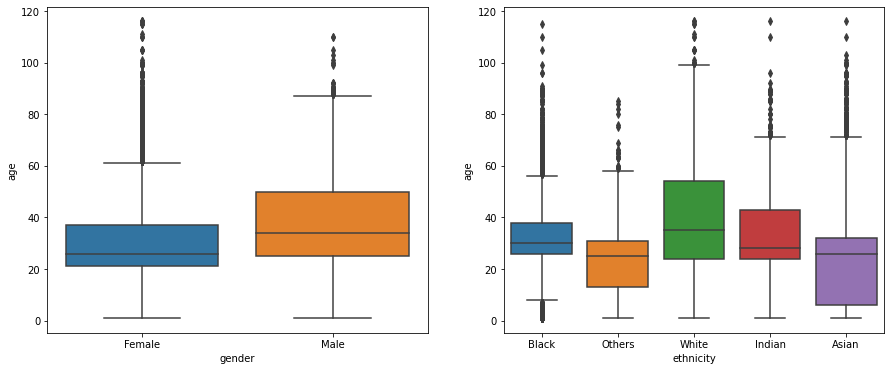

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
_ = sns.boxplot(data=df_str, x='gender', y='age', ax=ax1)
_ = sns.boxplot(data=df_str, x='ethnicity', y='age', ax=ax2)

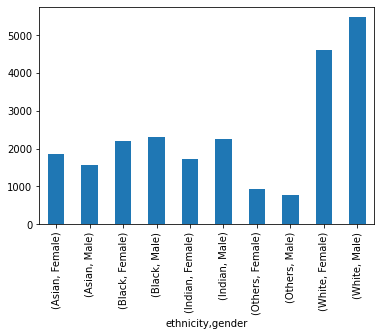

In [ ]:
df_str.groupby(by=['ethnicity', 'gender'])['age'].count().plot(kind='bar')

## 4) Générateur de données et augmentation

In [ ]:
class CustomDataGen(tf.keras.utils.Sequence):
    
    def __init__(self, df,
                 batch_size = 32,
                 input_size=(48, 48, 3),
                 shuffle=True,
                 data_augmentation = False):
        self.df = df
        self.batch_size = batch_size
        self.input_size = input_size
        self.data_augmentation = data_augmentation
        self.var = 1
        
        self.imageGenerator = ImageDataGenerator(
            horizontal_flip = True,
            #vertical_flip = True,
            fill_mode = 'nearest',
            zoom_range = (1, 1.1),
            width_shift_range = 0.1,
            height_shift_range = 0.1,
            rotation_range = 10
        )
        
        self.images = []
        self.age_labels = []        
        self.ethnicity_labels = []
        self.gender_labels = []
        
        for index, row in tqdm(df.iterrows()):
            image = np.fromstring(row['pixels'], sep = ' ', dtype = np.uint8).reshape((48,48))
            image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
            
            self.images.append(image)
            
            self.age_labels.append(row['age'])
            self.ethnicity_labels.append(row['ethnicity'])
            self.gender_labels.append(row['gender'])
            
            
        self.images = np.array(self.images)
        self.age_labels = np.array(self.age_labels).astype(np.float32)
        self.ethnicity_labels = np.array(self.ethnicity_labels).astype(np.float32)
        self.gender_labels = np.array(self.gender_labels).astype(np.float32)
        
        p = np.random.permutation(len(self.age_labels))
        self.images = self.images[p]
        self.age_labels = self.age_labels[p]
        self.ethnicity_labels = to_categorical(self.ethnicity_labels[p], num_classes=5)
        self.gender_labels = self.gender_labels[p]
        
        self.n = len(self.df)
        
    
    def __getitem__(self, index):
        images = []
        
        for i in range(self.batch_size):
            image = self.images[index * self.batch_size + i]
            
            if self.data_augmentation:                
                image = self.imageGenerator.random_transform(image)
                
            images.append(image)
            
        s = slice(self.batch_size * index, (index + 1) * self.batch_size)
        return np.array(images), (self.age_labels[s], self.ethnicity_labels[s], self.gender_labels[s])
    
    def __len__(self):
            
        return self.n // self.batch_size
    
    def on_epoch_end(self):
        
        #Random permutation
        p = np.random.permutation(len(self.age_labels))
        self.images = self.images[p]
        self.age_labels = self.age_labels[p]
        self.ethnicity_labels = self.ethnicity_labels[p]
        self.gender_labels = self.gender_labels[p]

## 5) Répartition des données en subsets d'entraînement, de validation et de test (80/10/10)

In [ ]:
#Divide into train and validation
w_train, w_val, w_test = 0.8, 0.1, 0.1

choices = random.choices(population=[0, 1, 2], weights=[w_train, w_val, w_test], k=len(dataframe))

msk_train = np.array([choice==0 for choice in choices])
msk_val = np.array([choice==1 for choice in choices])
msk_test = np.array([choice==2 for choice in choices])

train = dataframe[msk_train]
val = dataframe[msk_val]
test = dataframe[msk_test]

train_dataset = CustomDataGen(train, data_augmentation = True)
val_dataset = CustomDataGen(val)
test_dataset = CustomDataGen(test)

19080it [00:03, 5258.70it/s]
2319it [00:00, 7101.35it/s]
2306it [00:00, 6986.30it/s]


## 6) Création du modèle

In [ ]:
def build_model(input_shape = (48,48,3)):
    
    i = tf.keras.layers.Input(input_shape, dtype = tf.uint8)
    x = tf.cast(i, tf.float32)
    x = tf.keras.applications.vgg16.preprocess_input(x)
    
    backbone = tf.keras.applications.vgg16.VGG16(
                include_top=False, weights='imagenet',
                input_tensor=x
            )
    output_layer = backbone.get_layer("block5_conv3").output    
    
    
    def build_age_branch(input_tensor): 
        x = tf.keras.layers.Dense(1024, activation = LeakyReLU(alpha=0.3))(input_tensor)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Dropout(0.2)(x)
        x = tf.keras.layers.Dense(1, activation = None, name = 'age_output')(x)
    
        return x
    
    def build_etchnicity_branch(input_tensor): 
        x = tf.keras.layers.Dense(500, activation = LeakyReLU(alpha=0.3))(input_tensor)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Dropout(0.2)(x)
        x = tf.keras.layers.Dense(5, activation = 'softmax', name = 'ethnicity_output')(x)
    
        return x
    
    def build_gender_branch(input_tensor): 
        x = tf.keras.layers.Dense(500, activation = LeakyReLU(alpha=0.3))(input_tensor)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Dropout(0.2)(x)
        x = tf.keras.layers.Dense(1, activation = 'sigmoid', name = 'gender_output')(x)
    
        return x
    
    x = tf.keras.layers.Flatten()(output_layer)       
    output_age = build_age_branch(x)
    output_ethnicity = build_etchnicity_branch(x)
    output_gender = build_gender_branch(x)
    model = tf.keras.Model(i, [output_age, output_ethnicity, output_gender])
    
    return model
    

In [ ]:
model = build_model()
model.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 48, 48, 3)]  0           []                               
                                                                                                  
 tf.cast (TFOpLambda)           (None, 48, 48, 3)    0           ['input_1[0][0]']                
                                                                                                  
 tf.__operators__.getitem (Slic  (None, 48, 48, 3)   0           ['tf.cast[0][0]']                
 ingOpLambda)                                                                                     
                                                                                                  
 tf.nn.bias_add (TFOpLambda) 

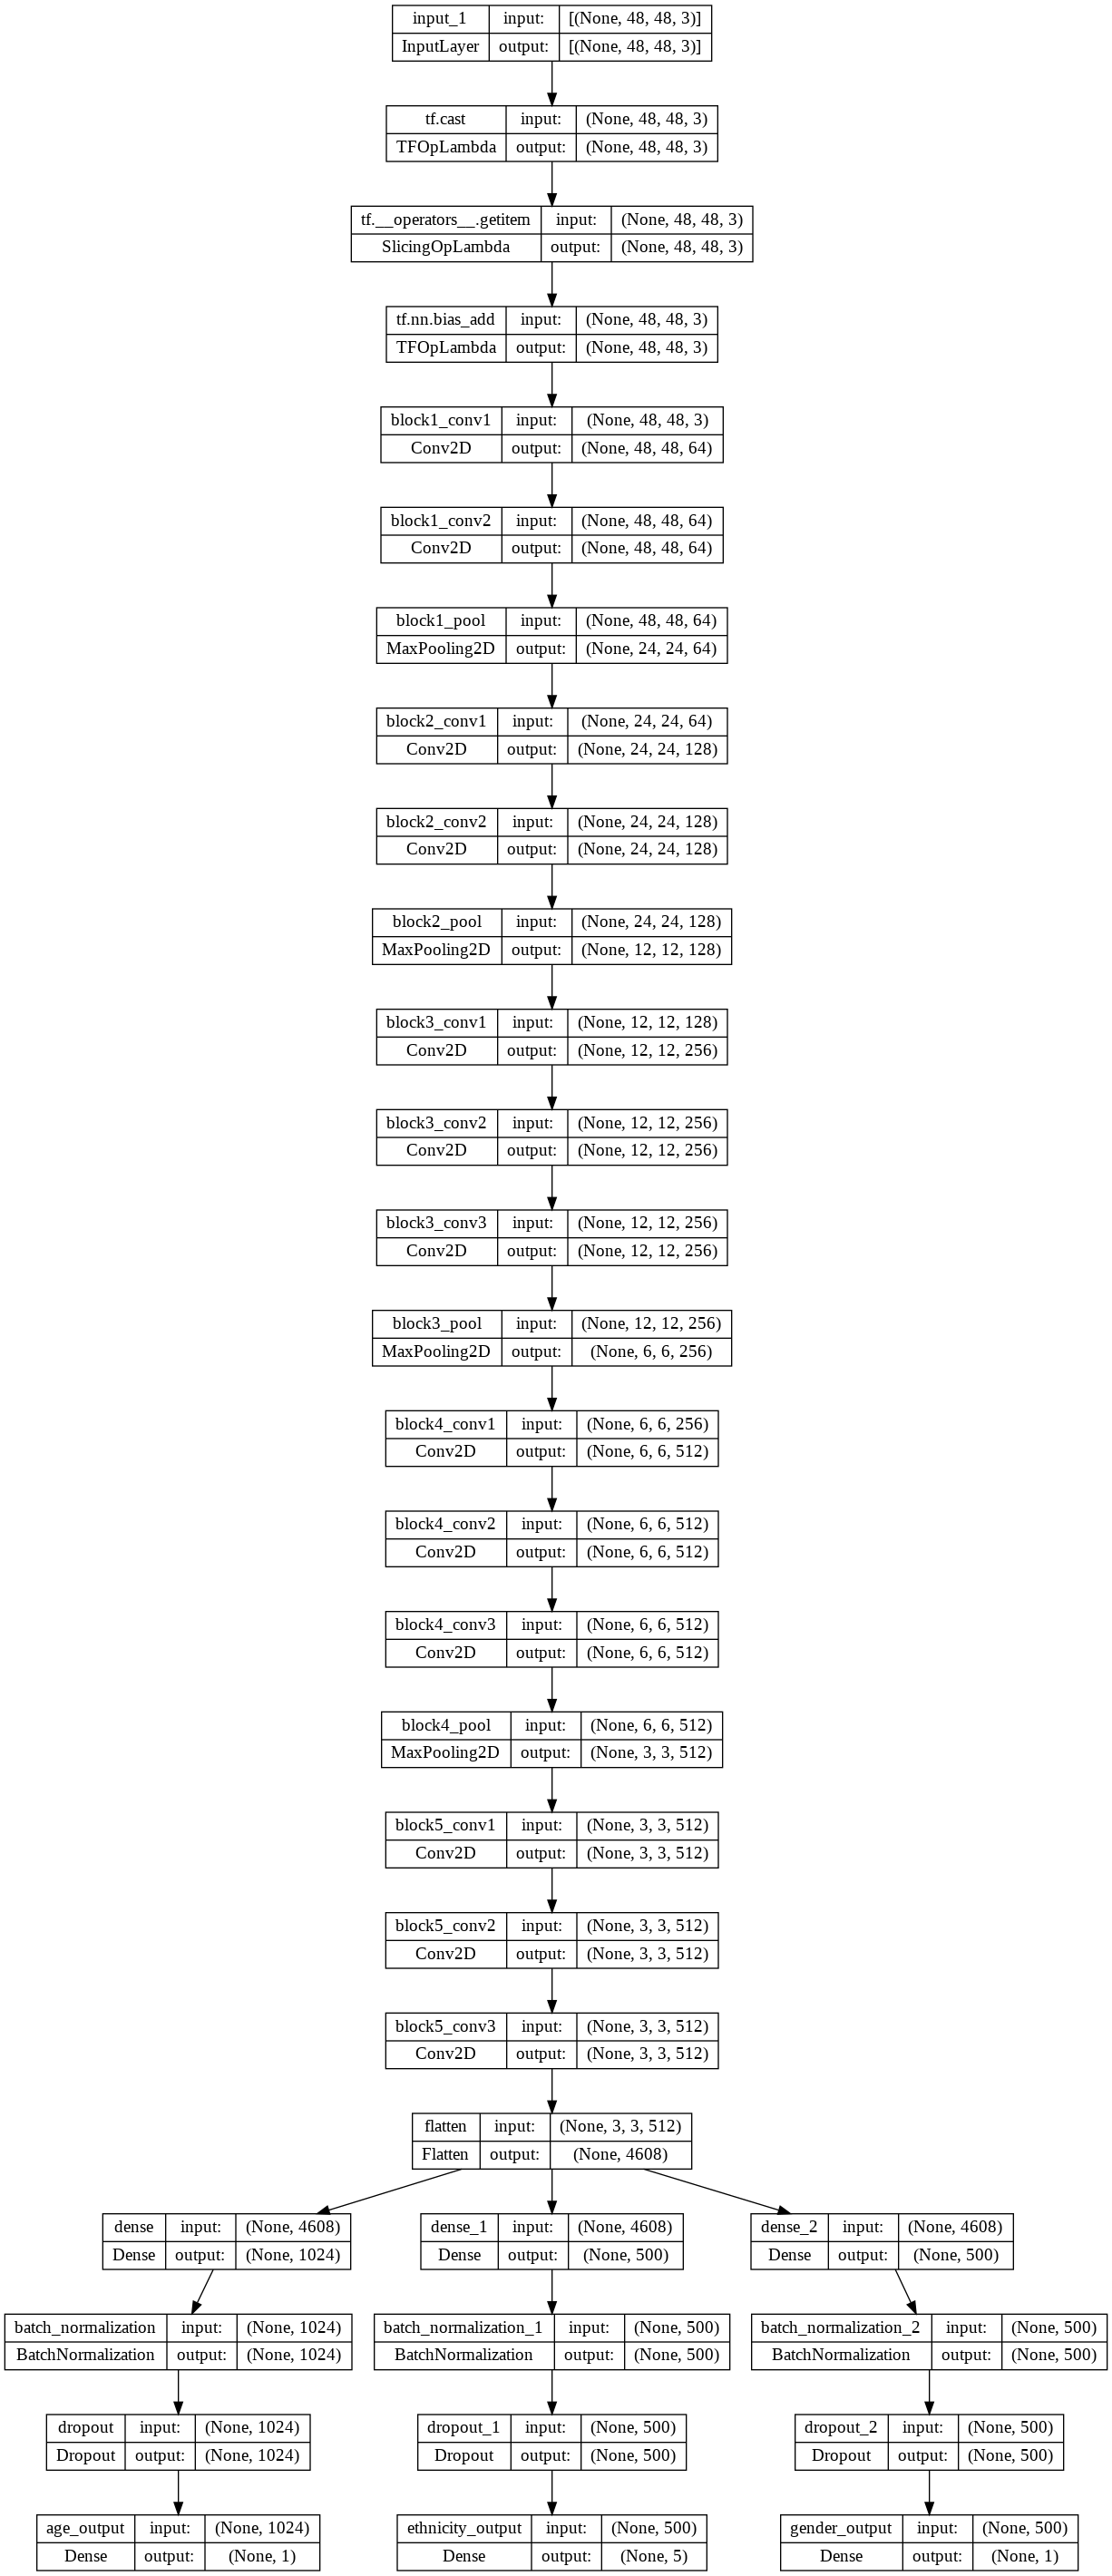

In [ ]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True, expand_nested=False)

## 7) Entraînement du modèle

In [ ]:
model.compile(tf.keras.optimizers.Adam(learning_rate=1e-4), loss = ['mse', 'categorical_crossentropy', 'binary_crossentropy'], loss_weights = [0.001,0.5,0.5], 
              metrics = {'age_output': 'mean_absolute_error', 'ethnicity_output': 'accuracy', 'gender_output': 'accuracy'})

plateau = tf.keras.callbacks.ReduceLROnPlateau(
      monitor='val_loss', factor=0.3, patience=2, verbose = 1
)
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1,
                                      patience=5)  # Early stopping (stops training when validation doesn't improve for {patience} epochs)
save_best = tf.keras.callbacks.ModelCheckpoint('weights.h5', monitor='val_loss', save_best_only=True,
                                            mode='min', save_weights_only = True)  # Saves the best version of the model to disk (as measured on the validation data set)
remote_monitor_callback = tf.keras.callbacks.RemoteMonitor(
    root='https://dweet.io', path='/dweet/for/multitask',
    send_as_json=False, field = 'data'
)     

history = model.fit(train_dataset,
            epochs=EPOCHS,
            batch_size = BATCH_SIZE,
            validation_data=val_dataset,
            callbacks = [es, save_best, plateau, remote_monitor_callback])

Epoch 1/70
596/596 [==============================] - 40s 48ms/step - loss: 1.9708 - age_output_loss: 1200.6566 - ethnicity_output_loss: 1.1049 - gender_output_loss: 0.4355 - age_output_mean_absolute_error: 32.0072 - ethnicity_output_accuracy: 0.6173 - gender_output_accuracy: 0.8072 - val_loss: 1.9522 - val_age_output_loss: 1078.3253 - val_ethnicity_output_loss: 1.4020 - val_gender_output_loss: 0.3457 - val_age_output_mean_absolute_error: 31.0403 - val_ethnicity_output_accuracy: 0.5994 - val_gender_output_accuracy: 0.8464 - lr: 1.0000e-04
Epoch 2/70
596/596 [==============================] - 29s 48ms/step - loss: 1.4007 - age_output_loss: 826.2322 - ethnicity_output_loss: 0.8229 - gender_output_loss: 0.3260 - age_output_mean_absolute_error: 26.4898 - ethnicity_output_accuracy: 0.7218 - gender_output_accuracy: 0.8646 - val_loss: 0.7154 - val_age_output_loss: 200.2935 - val_ethnicity_output_loss: 0.7702 - val_gender_output_loss: 0.2600 - val_age_output_mean_absolute_error: 11.8234 - val_

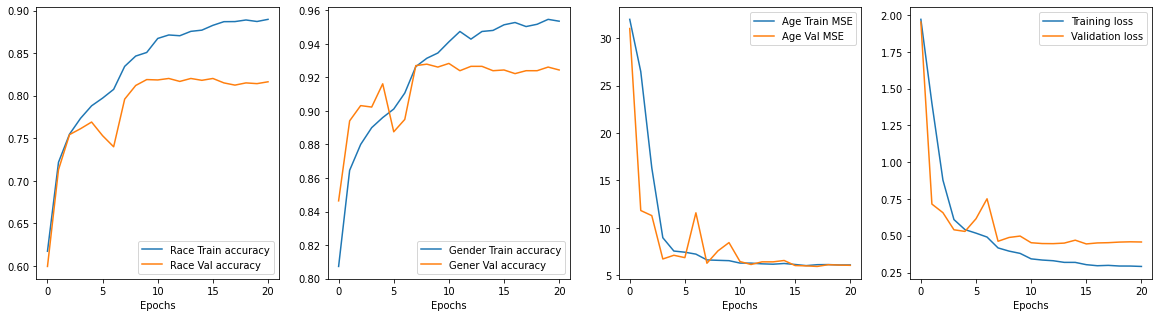

In [ ]:
def  plot_train_history(history):
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    axes[0].plot(history.history['ethnicity_output_accuracy'], label='Race Train accuracy')
    axes[0].plot(history.history['val_ethnicity_output_accuracy'], label='Race Val accuracy')
    axes[0].set_xlabel('Epochs')
    axes[0].legend()
    
    axes[1].plot(history.history['gender_output_accuracy'], label='Gender Train accuracy')
    axes[1].plot(history.history['val_gender_output_accuracy'], label='Gener Val accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].legend()

    axes[2].plot(history.history['age_output_mean_absolute_error'], label='Age Train MSE')
    axes[2].plot(history.history['val_age_output_mean_absolute_error'], label='Age Val MSE')
    axes[2].set_xlabel('Epochs')
    axes[2].legend()  

    axes[3].plot(history.history['loss'], label='Training loss')
    axes[3].plot(history.history['val_loss'], label='Validation loss')
    axes[3].set_xlabel('Epochs')
    axes[3].legend()

plot_train_history(history)

## 8) Evaluation du modèle

In [ ]:
model.load_weights('weights.h5')
model.evaluate(test_dataset)

72/72 [==============================] - 1s 17ms/step - loss: 0.4219 - age_output_loss: 69.7688 - ethnicity_output_loss: 0.5015 - gender_output_loss: 0.2028 - age_output_mean_absolute_error: 5.9993 - ethnicity_output_accuracy: 0.8377 - gender_output_accuracy: 0.9223


[0.4219058156013489,
 69.76883697509766,
 0.5014922022819519,
 0.20278188586235046,
 5.9993205070495605,
 0.8376736044883728,
 0.9223090410232544]

In [ ]:
names_ethnicity = ['white', 'black', 'asian', 'indian', 'other']
names_gender = ['male', 'female']

1/1 [==============================] - 0s 20ms/step


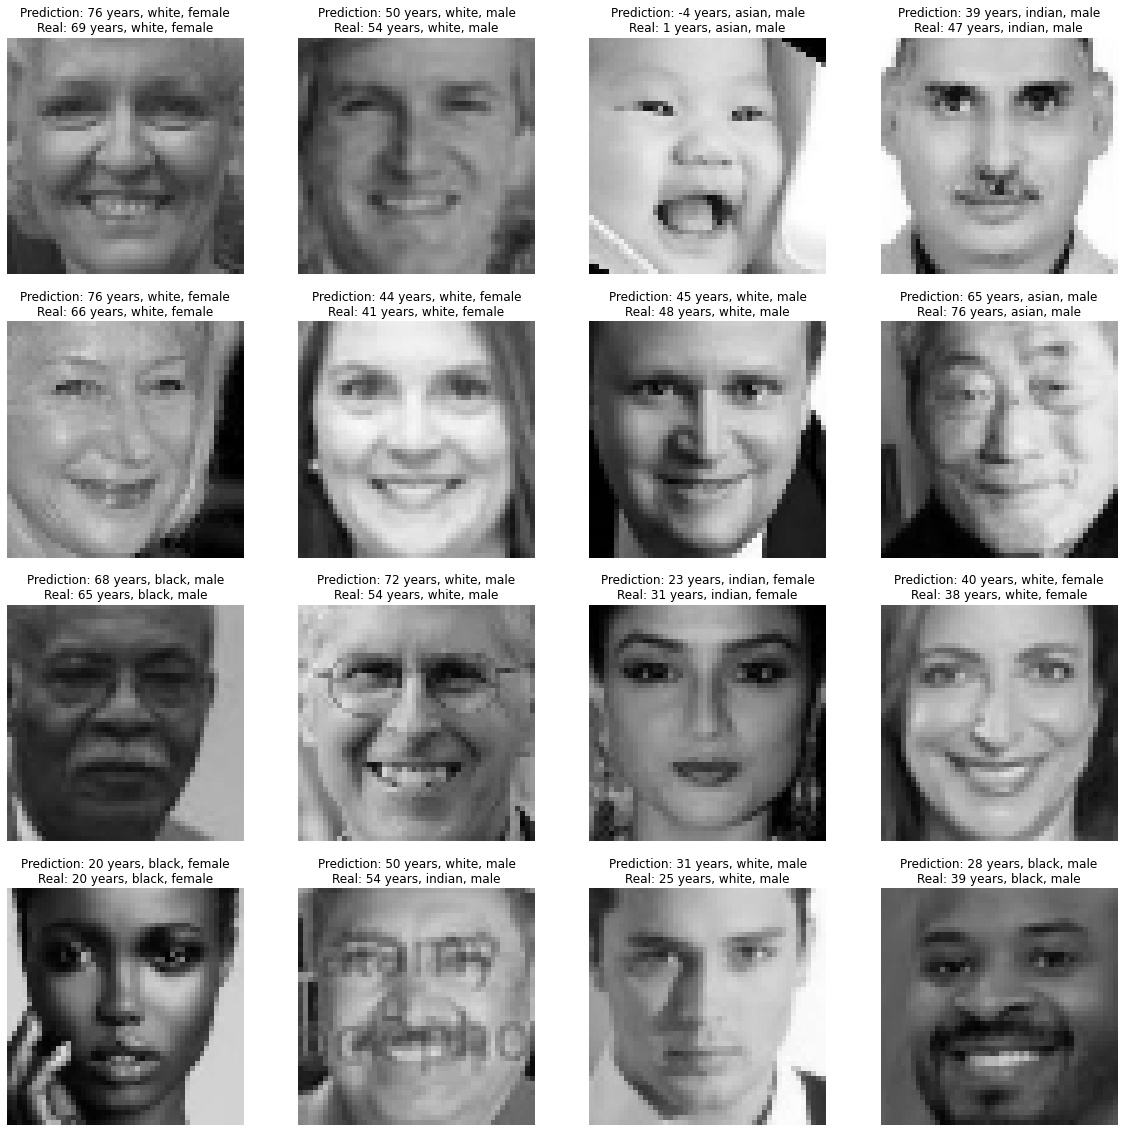

In [ ]:
images, labels = test_dataset[22]
p = model.predict(images)
gender_predictions = tf.where(p[2] > 0.5, 1, 0)


fig, axes = plt.subplots(4, 4, figsize=(20, 20))

for ax in axes.ravel():
    ax.axis("off")
    
for i, ax in enumerate(axes.flat):
    ax = axes.flat[i]
    ax.imshow(images[i], cmap='hsv')
    ax.set_title(f'Prediction: {p[0][i].astype(np.int64)[0]} years, {names_ethnicity[p[1][i].argmax()]}, {names_gender[gender_predictions[i][0]]}\n'+
        f'Real: {int(labels[0][i])} years, {names_ethnicity[labels[1][i].argmax()]}, {names_gender[int(labels[2][i])]}')

plt.show()

In [ ]:
age_labels = []
ethnicity_labels = []
gender_labels = []

age_pred = []
ethnicity_pred = []
gender_pred = []
gender_th = 0.5

for i in range(test_dataset.__len__()):
  images, labels = test_dataset[i]
  p = model.predict(images)

  for j in range(BATCH_SIZE):
    age_pred.append(round(p[0][j][0]))
    ethnicity_pred.append(p[1][j].argmax())
    gender_pred.append(1 if p[2][j][0] >= gender_th else 0)

    age_labels.append(int(labels[0][j]))
    ethnicity_labels.append(labels[1][j].argmax())
    gender_labels.append(int(labels[2][j]))

1/1 [==============================] - 0s 22ms/step


In [ ]:
ethnicity_labels_str = [names_ethnicity[ethnicity_labels[i]] for i in range(len(ethnicity_labels))]
ethnicity_pred_str = [names_ethnicity[ethnicity_pred[i]] for i in range(len(ethnicity_pred))]

gender_labels_str = [names_gender[gender_labels[i]] for i in range(len(gender_labels))]
gender_pred_str = [names_gender[gender_pred[i]] for i in range(len(gender_pred))]

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
print(classification_report(ethnicity_pred, ethnicity_labels_str))

              precision    recall  f1-score   support

       asian       0.83      0.92      0.88       304
       black       0.91      0.88      0.89       449
      indian       0.77      0.81      0.79       382
       other       0.39      0.45      0.41       137
       white       0.91      0.86      0.88      1032

    accuracy                           0.84      2304
   macro avg       0.76      0.78      0.77      2304
weighted avg       0.84      0.84      0.84      2304



In [ ]:
print(classification_report(gender_labels_str, gender_pred_str))

              precision    recall  f1-score   support

      female       0.93      0.91      0.92      1089
        male       0.92      0.94      0.93      1215

    accuracy                           0.92      2304
   macro avg       0.92      0.92      0.92      2304
weighted avg       0.92      0.92      0.92      2304



In [ ]:
import math

def manhattan_dist(y_true, y_pred):
  dist = 0
  for i in range(len(y_true)):
    dist += math.sqrt(abs(y_true[i] - y_pred[i]))
  return dist / len(y_true)

def euclidean_dist(y_true, y_pred):
  dist = 0
  for i in range(len(y_true)):
    dist += math.sqrt((y_true[i] - y_pred[i])**2)
  return dist / len(y_true)

print("Euclidean dist: " + str(euclidean_dist(age_pred, age_labels)))
print("Manhattan dist: " + str(manhattan_dist(age_pred, age_labels)))

Euclidean dist: 6.003472222222222
Manhattan dist: 2.1546193482017832


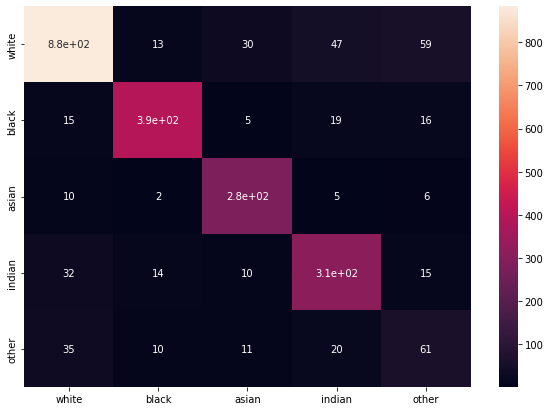

In [ ]:
cm_ethnicity = confusion_matrix(ethnicity_pred_str, ethnicity_labels_str, labels=names_ethnicity)

df_cm_ethnicity = pd.DataFrame(cm_ethnicity, index = names_ethnicity, columns = names_ethnicity)
plt.figure(figsize = (10,7))
sns.heatmap(df_cm_ethnicity, annot=True)

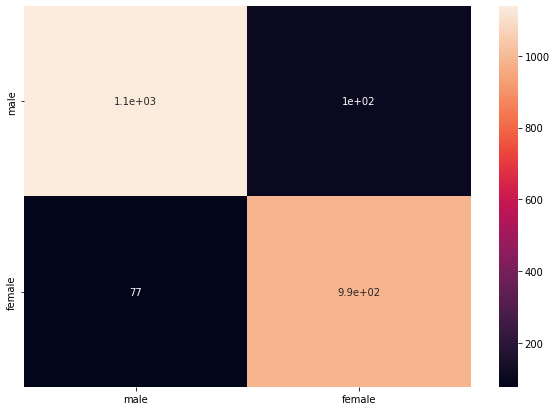

In [ ]:
cm_gender = confusion_matrix(gender_pred_str, gender_labels_str, labels=names_gender)

df_cm_gender = pd.DataFrame(cm_gender, index = names_gender, columns = names_gender)
plt.figure(figsize = (10, 7))
sns.heatmap(df_cm_gender, annot=True)